In this notebook we tackle the problem of Customer segmentation which plays a crucial rule in modern customer-centric marketing. This Online Retail II data set contains all the transactions occurring for a UK-based and registered, non-store online retail between 01/12/2009 and 09/12/2010.The company mainly sells unique all-occasion gift-ware. Many customers of the company are wholesalers. The dataset is available at <a href="https://archive.ics.uci.edu/ml/datasets/Online+Retail+II">UCI datasets</a>.<br/>

**Contents:**
* 1. Data exploring and preprocessing.
* 2. Feature engineering.
* 3. Modeling.
* 4. Cluster analysis.

In [1]:
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime
from dateutil.relativedelta import relativedelta
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

import sklearn.preprocessing as pp
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans, SpectralClustering, AgglomerativeClustering, AffinityPropagation, Birch, DBSCAN, OPTICS
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

%matplotlib inline
pd.set_option('precision', 2)
sns.set_style('whitegrid')

In [2]:
data = pd.read_excel('online_retail_II.xlsx')

# 1. Data exploring and preprocessing

* Basic data info, number of records and number of variables.

In [3]:
data.shape

(525461, 8)

In [4]:
data.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525461 entries, 0 to 525460
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      525461 non-null  object        
 1   StockCode    525461 non-null  object        
 2   Description  522533 non-null  object        
 3   Quantity     525461 non-null  int64         
 4   InvoiceDate  525461 non-null  datetime64[ns]
 5   Price        525461 non-null  float64       
 6   Customer ID  417534 non-null  float64       
 7   Country      525461 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 32.1+ MB


* Summary of the number and percentage of missing values in each variable.

In [6]:
# Identify the number of NAs in each feature and select only those having NAs
total_NA = data.isnull().sum()[data.isnull().sum() != 0]

# Calculate the percentage of NA in each feature
percent_NA = data.isnull().sum()[data.isnull().sum() != 0]/data.shape[0]

# Summarize our findings in a dataframe
missing = pd.concat([total_NA, percent_NA], axis=1, keys=['Total NAs', 'Percentage']).sort_values('Total NAs', ascending=False)
missing

,Total NAs,Percentage
Customer ID,107927,2.05e-01
Description,2928,5.57e-03


* Transactions with missing Customer IDs are not useful for creating customers segments. So, we drop them.

In [7]:
# Drop transactions with missing Customer ID
data.dropna(axis=0, subset=['Customer ID'], inplace= True)

* Check duplicated records

In [8]:
print('Number of duplicated records: ', data.duplicated(keep='first').sum())

Number of duplicated records:  6771


Drop duplicated records.

In [9]:
indx = data[data.duplicated(keep='first')].index
data.drop(index = indx, inplace= True)

* Assert that StockCode and Customer ID are of string data type not integers or floats.

In [10]:
data['StockCode'] = data['StockCode'].astype(str)

In [11]:
# Fill any missing or null values in the 'Customer ID' column and then convert it to a string
data['Customer ID'] = data['Customer ID'].fillna(0).astype(int).astype(str)

* Number of different data types in the dataset.

In [12]:
data.dtypes.value_counts()

object            5
int64             1
datetime64[ns]    1
float64           1
dtype: int64

* Generate summary statistics for all categorical variables.

In [13]:
# Summary statistics of categorical variables
data.select_dtypes(include='object').describe().T

,count,unique,top,freq
Invoice,410763,23587,500356,251
StockCode,410763,4031,85123A,3199
Description,410763,4459,WHITE HANGING HEART T-LIGHT HOLDER,3199
Customer ID,410763,4383,14911,5707
Country,410763,37,United Kingdom,372705


* Generate descriptive statistics for the "InvoiceDate" variable.

In [14]:
# Summary statistics of "InvocieDate" variable
data[['InvoiceDate']].describe().T

,count,unique,top,freq,first,last
InvoiceDate,410763,21786,2010-03-07 15:34:00,251,2009-12-01 07:45:00,2010-12-09 20:01:00


* Generate summary statistics for all numerical variables.

In [15]:
# Summary statistics of numeric variables
data.select_dtypes(include= ['int64', 'float64']).describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Quantity,410763.0,12.92,102.04,-9360.0,2.00,5.00,12.00,19152.00
Price,410763.0,3.91,71.71,0.0,1.25,1.95,3.75,25111.09


* Customers from UK and Outside UK.

In [16]:
x = data.Country.apply(lambda x: x if x == 'United Kingdom' else 'Not UK').value_counts().rename('#Customers')
y = (x/data.shape[0]).rename('%Customers')
pd.concat([x, y], axis= 1)

,#Customers,%Customers
United Kingdom,372705,0.91
Not UK,38058,0.09


* Transactions with a letter 'C' at the beginning of its invoice numbers are canceled transactions, so we drop them.

In [17]:
# Drop cancelled transactions
indx = data.Invoice[data.Invoice.str.contains('C') == True].index
data.drop(index= indx, inplace= True)

* Some transaction have a sale price of zero, these could be free gifts for some customers and not true sales transaction. So, we will drop them.

In [18]:
# Drop transactions with price zero
indx = data.loc[data.Price == 0].index
data.drop(index= indx, inplace= True)

# 2. Feature Engineering

We will use the RFM model in addition to another two measures, First_purchase and No. of unique items, to create customer segments. RFM stands for *Recency, Frequency, and Monetary_value*:
* Recency: is a measure of how long it has been since a customer last placed an order with the company.<br/>
* First_purchase: Time in month since the first purchase.<br/>
* Frequency: is a measure of how often a customer orders from the company.<br/>
* Monetary Value: The a mount that a customer spends on an average transaction.<br/>
* Unique_items: is measure of the average number of unique items per transaction. This measure can be used to distinguish between organizational customers and individual customers.

* Calculate the sales amount for each transaction which is the product of sale price and quantity.

In [19]:
# Amount per transaction which is the product of sale price and quantity
data['Amount'] = data['Price'] * data['Quantity']

* Separate transaction time (in hours) from transaction date.

In [20]:
# Create new variable for Invoice time in hours
data['Transaction_time'] = data.InvoiceDate.apply(lambda x : x.time().hour)

In [21]:
# Create new variable for Invoice date
data['Transaction_date'] = data.InvoiceDate.apply(lambda x : x.date())
data['Transaction_date'] = data.Transaction_date.apply(lambda x: x.replace(day = 1))

* For each transaction, calculate the number of months since transaction date to the end of the year (Dec 2010).

In [22]:
# calculate the no. of months since transaction date .
ref = datetime.strptime('2010-12', '%Y-%m')
data['Mnths_since_purchase'] = data.Transaction_date.apply(lambda x: \
                                        relativedelta(ref,x).years*12 + relativedelta(ref,x).months)
Recency = data.groupby('Customer ID').agg({'Mnths_since_purchase' : 'min'}).copy().rename(columns= {'Mnths_since_purchase':'Recency'})

* For each customer, calculate the number of months since his/her first purchase.

In [23]:
# Calculate the number of months since the first purchase for each customer
data['First_purchase'] = data['Mnths_since_purchase'].copy()
First_purchase = data.groupby('Customer ID').agg({'First_purchase' : 'max'}).copy().rename(columns= {'Mnths_since_purchase':'First_purchase'})

* For each customer, calculate the average number of transactions per month (Frequency).

In [24]:
Frequency = data.groupby(['Customer ID',
                    'Transaction_date']).agg({'Invoice' : 'nunique'}).groupby(['Customer ID']).agg({'Invoice' : 'mean'}).copy().rename(columns= {'Invoice':'Frequency'})

* For each customer, calculate the average purchase amount per transaction (Monetary value).

In [25]:
Monetary_value = data.groupby(['Customer ID',
                    'Invoice']).agg({'Amount' : 'sum'}).groupby(['Customer ID']).agg({'Amount' : 'mean'}).copy().rename(columns= {'Invoice':'Frequency',
                                                              'Amount': 'Monetary_value'})

* For each customer, calculate the average number of unique items in each transaction.

In [26]:
# Calculate Average number of unique items in each transaction for each customer
unique_items = data.groupby(['Customer ID', 'Invoice']).agg({'StockCode': 'nunique'}).groupby(['Customer ID']\
            ).agg({'StockCode':'mean'}).rename(columns={'StockCode': 'Unique_items'})

In [27]:
# Convert the string column to a numerical data type
data["Description"] = pd.to_numeric(data["Description"], errors="coerce")

* Assemble all new features into a new data frame to be used for model training later.

In [28]:
# Create transformed data for Clustering
data_transformed = pd.concat([Recency, First_purchase, Frequency, Monetary_value,unique_items], axis=1)
data_transformed.describe()

,Recency,First_purchase,Frequency,Monetary_value,Unique_items
count,4312.00,4312.00,4312.00,4312.00,4312.00
mean,3.17,7.55,1.26,376.37,21.32
std,3.19,3.85,0.69,492.36,17.70
min,0.00,0.00,1.00,2.95,1.00
25%,1.00,4.00,1.00,179.49,9.67
50%,2.00,8.00,1.00,285.05,17.33
75%,5.00,11.00,1.33,421.48,27.00
max,12.00,12.00,19.38,11880.84,220.00


* Plot the distribution for all variables to detect potential outliers and decide whether normalization is needed.

<AxesSubplot:xlabel='Unique_items'>

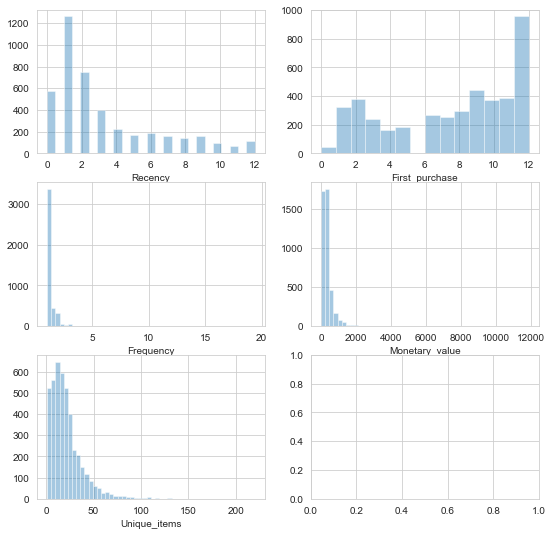

In [29]:
# Plot the distribution of all variables that will be used for model training
fig, ax = plt.subplots(ncols=2, nrows=3, figsize=(9,9))
sns.distplot(data_transformed.Recency, ax= ax[0][0], kde= False)
sns.distplot(data_transformed.First_purchase, ax= ax[0][1], kde= False)
sns.distplot(data_transformed.Frequency, ax= ax[1][0], kde= False)
sns.distplot(data_transformed.Monetary_value, ax= ax[1][1], kde= False)
sns.distplot(data_transformed.Unique_items, ax= ax[2][0], kde= False)

The plots show some potential outliers in both frequency and Monetary value, so we will drop those customers from our dataset. Such that customers having more than Mean + 3 Std (i.e. Z-score > 3). will be dropped.

In [30]:
# Define frequency threshold value and drop customers who exceed the threshold
freq_stats = data_transformed['Frequency'].describe()
freq_threshold = freq_stats['mean'] + 3 * freq_stats['std']
indx = data_transformed.loc[data_transformed.Frequency > freq_threshold].index
data_transformed.drop(index = indx, inplace= True)

In [31]:
# Define Monetary value threshold value and drop customers who exceed the threshold
m_stats = data_transformed['Monetary_value'].describe()
m_threshold = m_stats['mean'] + 3 * m_stats['std']
indx = data_transformed.loc[data_transformed.Monetary_value > m_threshold].index
data_transformed.drop(index = indx, inplace= True)

<AxesSubplot:xlabel='Unique_items'>

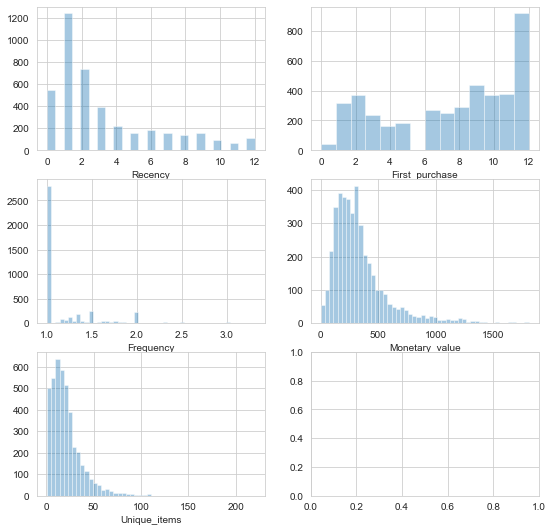

In [32]:
fig, ax = plt.subplots(ncols=2, nrows=3, figsize=(9,9))
sns.distplot(data_transformed.Recency, ax= ax[0][0], kde= False)
sns.distplot(data_transformed.First_purchase, ax= ax[0][1], kde= False)
sns.distplot(data_transformed.Frequency, ax= ax[1][0], kde= False)
sns.distplot(data_transformed.Monetary_value, ax= ax[1][1], kde= False)
sns.distplot(data_transformed.Unique_items, ax= ax[2][0], kde= False)

* Plots show that variables have very different scales and some of them are heavily skewed. So we will normalize all variables.

In [33]:
# Normalize the four variables
scaler = pp.StandardScaler()
data_transformed_scaled = pd.DataFrame(scaler.fit_transform(data_transformed),
                                       columns= data_transformed.columns)

<AxesSubplot:xlabel='Unique_items'>

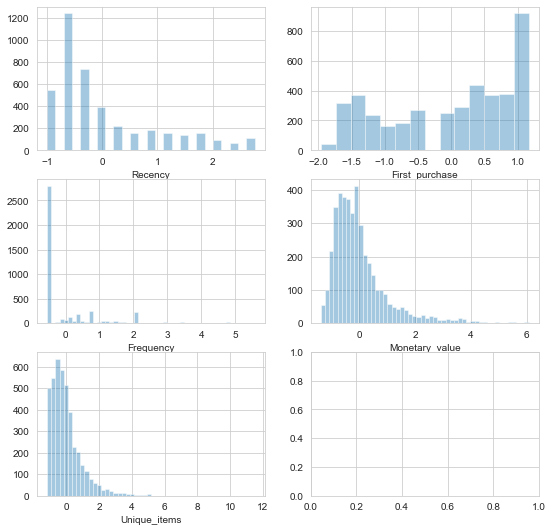

In [34]:
fig, ax = plt.subplots(ncols=2, nrows=3, figsize=(9,9))
sns.distplot(data_transformed_scaled.Recency, ax= ax[0][0], kde= False)
sns.distplot(data_transformed_scaled.First_purchase, ax= ax[0][1], kde= False)
sns.distplot(data_transformed_scaled.Frequency, ax= ax[1][0], kde= False)
sns.distplot(data_transformed_scaled.Monetary_value, ax= ax[1][1], kde= False)
sns.distplot(data_transformed_scaled.Unique_items, ax= ax[2][0], kde= False)

# 3. Model training

## 3.1 Trying bunch of candidate models

We will start by trying a bunch of clustering algorithms and select most promising ones. Since the ground truth labels are not known, evaluation will be performed using the model itself. We will use three measures to evaluate clustering models:<br/>
 * Davies Bouldin Score:it signifies the average similarity between clusters, where the similarity is a measure that compares the distance between clusters with the size of the clusters themselves. Zero is the lowest possible score. Values closer to zero indicate a better partition.
 * Calinski Harabasz Score (also known as the Variance Ratio Criterion): it is the ratio of the sum of between-clusters dispersion and of inter-cluster dispersion for all clusters (where dispersion is defined as the sum of distances squared). The score is higher when clusters are dense and well separated.
 * Silhouette Score: The score is bounded between -1 for incorrect clustering and +1 for highly dense clustering. Scores around zero indicate overlapping clusters

In [35]:
# A function to automate the model fiting and prediction
def model_train(estimator, data, a,b):
    db = []
    ca = []
    sc = []
    bic = []
    aic = []
    n_clusters = {'n_clusters':[]}
    if (estimator == AffinityPropagation)|(estimator == DBSCAN)|(estimator == OPTICS)|(estimator==Birch):
        est = estimator()
        est.fit(data)  
        labels = est.labels_
        if np.unique(est.labels_).shape[0] > 1:
            db.append(davies_bouldin_score(data, labels))
            ca.append(calinski_harabasz_score(data, labels))
            sc.append(silhouette_score(data, labels))
            n_clusters['n_clusters'].append('N/A')
        else:
            n_clusters['n_clusters'].append(np.unique(est.labels_).shape[0])
    
    else:
        for k in range(a, b):
            if estimator == GaussianMixture:
                est = estimator(n_components= k)
                labels = est.fit_predict(data)
            else:
                est = estimator(n_clusters= k)
                est.fit(data)
                labels = est.labels_

            db.append(davies_bouldin_score(data, labels))
            ca.append(calinski_harabasz_score(data, labels))
            sc.append(silhouette_score(data, labels))

        n_clusters['n_clusters'].append(np.argmin(db) + a)
        n_clusters['n_clusters'].append(np.argmax(ca) + a)
        n_clusters['n_clusters'].append(np.argmax(sc) + a)
    return db, ca, sc, labels, n_clusters['n_clusters']

In [36]:
#Plot different measures against No. of clusters for algorithms requiring no. of clusters a priori.
def plot_scores(a,b, db, ca, sc):
    fig, ax = plt.subplots(nrows= 1, ncols=3, figsize=(15,4))
    ax[0].plot(range(a, b), db, "bo-", label= 'Davies_Bouldin_Score')
    ax[1].plot(range(a, b), ca, "rx-", label = 'Calinski_Harabasz_Score')
    ax[2].plot(range(a, b), sc, "g.-", label = 'Silhouette_Score')
    ax[0].set_xlabel("$k$", fontsize=14)
    ax[1].set_xlabel("$k$", fontsize=14)
    ax[2].set_xlabel("$k$", fontsize=14)
    ax[0].set_ylabel('Davies Bouldin Score', fontsize=14)
    ax[1].set_ylabel('Calinski Harabasz Score', fontsize=14)
    ax[2].set_ylabel('Silhouette Score', fontsize=14)
#     plt.legend(loc=(1,0),fontsize=14)
    plt.show()

We will try training the following algorithms:<br/>
* KMeans.
* Affinity Propagation.
* Agglomerative hierarchical clustering.
* Birch.
* DBSCAN.
* Gaussian Mixture Model.
* OPTICS.
* Spectral Clustering.

For those algorithms need the number of clusters a priori we will try the range of values between 3 and 7 and select the best model based on evaluation metrics.

In [37]:
clusterers = [KMeans, AffinityPropagation, AgglomerativeClustering, Birch,
             DBSCAN, GaussianMixture, OPTICS, SpectralClustering]

Scores ={'Davies_Bouldin_Score': [], 
         'Calinski_Harabasz_Score': [],
         'Silhouette_Score': [],
        'n_clusters': []}

clusterer_names = ['KMeans', 'Affinity Propagation', 'Agglomerative Clustering', 'Birch',
             'DBSCAN', 'Gaussian Mixture Model', 'OPTICS', 'Spectral Clustering']

for i in clusterers:
    db, ca, sc, labels, n_clusters= model_train(i, data_transformed_scaled, 3, 8)

    Scores['Davies_Bouldin_Score'].append(np.min(db))
    Scores['Calinski_Harabasz_Score'].append(np.max(ca))
    Scores['Silhouette_Score'].append(np.max(sc))
    Scores['n_clusters'].append(n_clusters)

In [38]:
models_scores = pd.DataFrame(Scores, index= clusterer_names)
models_scores

,Davies_Bouldin_Score,Calinski_Harabasz_Score,Silhouette_Score,n_clusters
KMeans,1.12,1330.83,0.31,"[5, 5, 6]"
Affinity Propagation,1.16,385.82,0.20,[N/A]
Agglomerative Clustering,1.25,1058.00,0.27,"[6, 5, 6]"
Birch,1.47,740.65,0.30,[N/A]
DBSCAN,1.54,54.46,-0.28,[N/A]
Gaussian Mixture Model,1.92,446.89,0.12,"[4, 3, 3]"
OPTICS,1.29,10.55,-0.39,[N/A]
Spectral Clustering,0.20,51.89,0.69,"[4, 6, 3]"


## 3.2 Select a few promising models

* **Best model according to "Davies_Bouldin_Score":**

In [39]:
models_scores.loc[models_scores.Davies_Bouldin_Score == models_scores.Davies_Bouldin_Score.min()]

,Davies_Bouldin_Score,Calinski_Harabasz_Score,Silhouette_Score,n_clusters
Spectral Clustering,0.2,51.89,0.69,"[4, 6, 3]"


* **Best model according to "Calinski_Harabasz_Score":**

In [40]:
models_scores.loc[models_scores.Calinski_Harabasz_Score == models_scores.Calinski_Harabasz_Score.max()]

,Davies_Bouldin_Score,Calinski_Harabasz_Score,Silhouette_Score,n_clusters
KMeans,1.12,1330.83,0.31,"[5, 5, 6]"


* **Best model according to "Silhouette_Score":**

In [41]:
models_scores.loc[models_scores.Silhouette_Score == models_scores.Silhouette_Score.max()]

,Davies_Bouldin_Score,Calinski_Harabasz_Score,Silhouette_Score,n_clusters
Spectral Clustering,0.2,51.89,0.69,"[4, 6, 3]"


Now, we have 3 promising models, Spectral clustering with 3, and 4 clusters and Kmeans with 5 clusters. Next, we will find the best model with the best number of clusters that results in clearest interpretation of separation between clusters.

## 3.3 Optimize selected models

In [42]:
def cluster_stats(model, data, data_transformed):
    df = data_transformed.copy()
    df['Cluster'] = pd.Series(model.labels_, name= 'Cluster', index= data_transformed.index)
    df['No._Purchases'] = data.groupby('Customer ID')['Invoice'].count()[df.index]
    df['Total_Amount'] = data.groupby('Customer ID')['Amount'].sum()[df.index]
    cluster_stats = df.groupby('Cluster').agg({'Recency': ['min', 'mean','max'],
                                       'Frequency': ['min', 'mean','max'],
                                       'Monetary_value': ['min', 'mean','max'],
                                       'First_purchase': ['min', 'mean','max'],
                                       'Unique_items': ['min', 'mean','max']}).copy().round(1)
    return cluster_stats, df

In [43]:
def clusters_summary(df, data):
    columns = {'#Customers':[], '#Purchases':[], 'Total_Amount':[]}
    indx =[]
    for i in np.sort(df.Cluster.unique()):
        columns['#Customers'].append(data.iloc[df.loc[df.Cluster == i].index].shape[0])
        columns['#Purchases'].append(df['No._Purchases'].loc[df.Cluster == i].sum())
        columns['Total_Amount'].append(df['Total_Amount'].loc[df.Cluster == i].sum())
        indx.append('Cluster{}'.format(i))
    
    # Synthesis a data frame for cluster summanry
    clusters_summary = pd.DataFrame(data= columns, index = indx)

    clusters_summary['%customers'] = (clusters_summary['#Customers']/df.shape[0])*100
    clusters_summary['%transactions'] = (clusters_summary['#Purchases']/df['No._Purchases'].sum())*100
    clusters_summary['%sales_amount'] = (clusters_summary['Total_Amount']/df['Total_Amount'].sum())*100
    columnsOrder = ['#Customers', '%customers', '#Purchases', '%transactions', 'Total_Amount', '%sales_amount']
    return clusters_summary.reindex(columns=columnsOrder)    

In [44]:
def plot_3d(cluster_stat):
    fig = plt.figure(figsize=(9,7))
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(cluster_stat['Recency'], cluster_stat['Frequency'], cluster_stat['Monetary_value'],
                     c=cluster_stat['Cluster'], s=60, marker=".",
                         cmap= 'prism', edgecolor= 'k', linewidths= 0.6)
    # produce a legend with the unique colors from the scatter
#     legend1 = ax.legend(*scatter.legend_elements(),
#                         loc="center right", title="Customer Segments",
#               bbox_to_anchor=(0.75, 0, 0.5, 1), fontsize= 12)
#     ax.add_artist(legend1)
    ax.set_xlabel('Recency', fontsize= 12)
    ax.set_ylabel('Frequency', fontsize= 12)
    ax.set_zlabel('Monetary_value', fontsize= 12)

In [45]:
def plot_dist(df, col):
    n= df['Cluster'].nunique()
    mpl.rcParams['figure.figsize'] = (12,12)
    fig, ax = plt.subplots(ncols=2 , nrows= (n//2))
    k = 0
    h=0
    for j in col:
        for i in range(n):
            sns.distplot(df[j][df.Cluster ==i], hist= False, label= 'Cluster{}'.format(i),
                         ax= ax[k][h], kde= True)
        ax[k][h].set_xlabel('{}'.format(j), fontsize= 14)
        h+=1
        if h%2==0:
            h=0
            k +=1

### 1. Spectral Clustering

* Spectral Clustering with 3 Clusters:

In [46]:
specc_3 = SpectralClustering(n_clusters= 3).fit(data_transformed_scaled)

In [47]:
cluster_stats(specc_3, data, data_transformed)[0]

Recency          Frequency           Monetary_value                  \
            min mean max       min mean  max            min    mean     max   
Cluster                                                                       
0             0  3.2  12       1.0  1.2  3.3            3.0   336.0  1808.0   
1             1  1.5   2       1.0  1.2  1.5         1191.2  1194.9  1198.6   
2             6  6.0   6       1.0  1.0  1.0         1651.7  1651.7  1651.7   

        First_purchase          Unique_items                
                   min mean max          min   mean    max  
Cluster                                                     
0                    0  7.5  12          1.0   21.1  137.0  
1                    1  3.5   6        160.3  170.7  181.0  
2                    6  6.0   6        220.0  220.0  220.0

In [48]:
clusters_summary(cluster_stats(specc_3, data, data_transformed)[1], data)

,#Customers,%customers,#Purchases,%transactions,Total_Amount,%sales_amount
Cluster0,4211,99.93,349594,99.73,6.12e+06,99.89
Cluster1,2,0.05,707,0.20,4.79e+03,0.08
Cluster2,1,0.02,236,0.07,1.65e+03,0.03


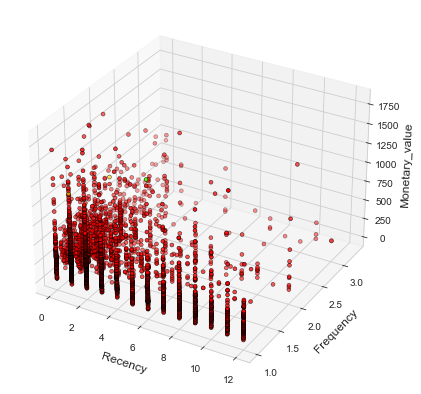

In [49]:
plot_3d(cluster_stats(specc_3, data, data_transformed)[1])

We can see that *Cluster0* alone contains 3424 which is 83.25 of the whole population accounting for 95.14 of the total sales amount! Clearly, this result in not meaning full.<br/>
Let's try Spectral Clustering with 4 clusters!

* Spectral Clustering with 4 clusters:

In [50]:
specc_4 = SpectralClustering(n_clusters= 4).fit(data_transformed_scaled)

In [51]:
cluster_stats(specc_4, data, data_transformed)[0]

Recency          Frequency           Monetary_value                  \
            min mean max       min mean  max            min    mean     max   
Cluster                                                                       
0             0  3.2  12       1.0  1.2  3.3            3.0   336.0  1808.0   
1             1  1.0   1       1.0  1.0  1.0         1191.2  1191.2  1191.2   
2             6  6.0   6       1.0  1.0  1.0         1651.7  1651.7  1651.7   
3             2  2.0   2       1.5  1.5  1.5         1198.6  1198.6  1198.6   

        First_purchase          Unique_items                
                   min mean max          min   mean    max  
Cluster                                                     
0                    0  7.5  12          1.0   21.1  137.0  
1                    1  1.0   1        181.0  181.0  181.0  
2                    6  6.0   6        220.0  220.0  220.0  
3                    6  6.0   6        160.3  160.3  160.3

In [52]:
clusters_summary(cluster_stats(specc_4, data, data_transformed)[1], data)

,#Customers,%customers,#Purchases,%transactions,Total_Amount,%sales_amount
Cluster0,4211,99.93,349594,99.73,6.12e+06,99.89
Cluster1,1,0.02,199,0.06,1.19e+03,0.02
Cluster2,1,0.02,236,0.07,1.65e+03,0.03
Cluster3,1,0.02,508,0.14,3.60e+03,0.06


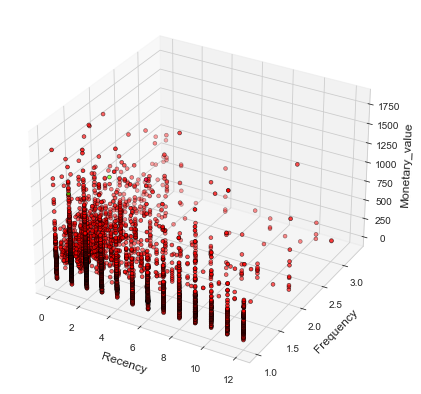

In [53]:
plot_3d(cluster_stats(specc_4, data, data_transformed)[1])

We can see that *Cluster1* alone contains 4034 which is 98.1 of the whole population accounting for 97.37 of the total sales amount! Also, this result in not meaning full.<br/>
Let's try KMeans with 5 clusters!

### 2. KMeans

* KMeans with 5 clusters:

In [54]:
kmeans = KMeans(n_clusters= 5, max_iter= 1000, random_state= 42).fit(data_transformed_scaled)

In [55]:
cluster_stats(kmeans, data, data_transformed)[0]

Recency          Frequency           Monetary_value                 \
            min mean max       min mean  max            min   mean     max   
Cluster                                                                      
0             0  1.8   5       1.0  1.0  1.7            3.8  252.1   724.6   
1             5  8.5  12       1.0  1.0  2.0            3.0  244.7   988.0   
2             0  1.6   6       1.0  1.2  1.8           21.6  316.4   901.6   
3             0  2.5  12       1.0  1.1  2.2          220.1  807.5  1808.0   
4             0  2.2  12       1.6  2.2  3.3           10.8  319.4  1359.7   

        First_purchase           Unique_items               
                   min  mean max          min  mean    max  
Cluster                                                     
0                    0   3.0   7          1.0  17.9   71.0  
1                    6   9.5  12          1.0  16.1   65.3  
2                    6  10.4  12          1.0  18.7   59.7  
3                    0   6.9  12          1.0  50.1  220.0  
4                    0   7.1  12          1.0  18.0   84.5

In [56]:
kmeans_cs = clusters_summary(cluster_stats(kmeans, data, data_transformed)[1], data)
kmeans_cs

,#Customers,%customers,#Purchases,%transactions,Total_Amount,%sales_amount
Cluster0,1149,27.27,37093,10.58,5.13e+05,8.38
Cluster1,845,20.05,21111,6.02,3.32e+05,5.42
Cluster2,1388,32.94,155353,44.32,2.66e+06,43.41
Cluster3,446,10.58,71895,20.51,1.32e+06,21.48
Cluster4,386,9.16,65085,18.57,1.31e+06,21.31


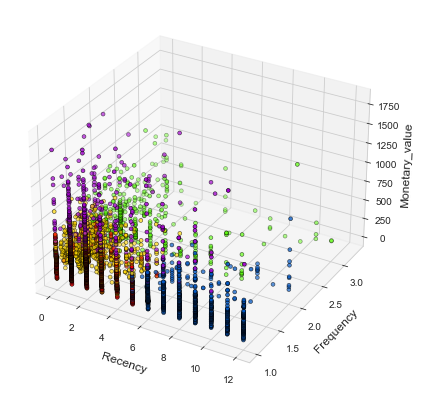

In [57]:
plot_3d(cluster_stats(kmeans, data, data_transformed)[1])

By examining the above summary data frames and figure, we can notice that KMeans actually results in better cluster separation compared to spectral clustering. However, the results doesn't seem very informative and we thick we can get better solution by further model optimization. Hence, we will recheck the best number of clusters for KMeans.

In [58]:
Scores ={'Davies_Bouldin_Score': [], 
         'Calinski_Harabasz_Score': [],
         'Silhouette_Score': []}

for k in range(4,9):
    kmeans = KMeans(n_clusters= k).fit(data_transformed_scaled)
    Scores['Davies_Bouldin_Score'].append(davies_bouldin_score(data_transformed_scaled, 
                                                               kmeans.labels_))
    Scores['Calinski_Harabasz_Score'].append(calinski_harabasz_score(data_transformed_scaled, 
                                                                     kmeans.labels_))
    Scores['Silhouette_Score'].append(silhouette_score(data_transformed_scaled, 
                                                       kmeans.labels_))

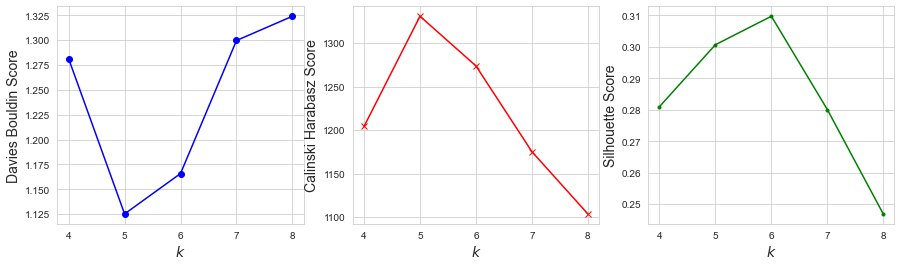

In [59]:
plot_scores(4,9,Scores['Davies_Bouldin_Score'], Scores['Calinski_Harabasz_Score'],
            Scores['Silhouette_Score'])

The plots of different evaluation metrics used at different K values indicates that K=6 can yield a good solution. So, we will examine this solution.

* KMeans with 6 clusters:

In [60]:
kmeans = KMeans(n_clusters= 6, max_iter= 1000, random_state= 42).fit(data_transformed_scaled)

In [61]:
kmeans_results = cluster_stats(kmeans, data, data_transformed)[1]
cluster_stats(kmeans, data, data_transformed)[0]

Recency          Frequency           Monetary_value                 \
            min mean max       min mean  max            min   mean     max   
Cluster                                                                      
0             0  2.2  10       1.0  1.1  2.0          148.0  438.4  1651.7   
1             0  2.7  12       1.0  1.2  2.5          556.5  954.7  1808.0   
2             0  1.6   6       1.0  1.2  1.8           21.6  309.3   794.4   
3             0  1.8   5       1.0  1.0  1.7            3.8  253.3   724.6   
4             0  2.2  12       1.6  2.2  3.3           10.8  308.7  1218.2   
5             5  8.5  12       1.0  1.0  2.0            3.0  243.1   906.2   

        First_purchase           Unique_items               
                   min  mean max          min  mean    max  
Cluster                                                     
0                    0   6.3  12         40.0  67.0  220.0  
1                    0   7.3  12          1.0  35.5  110.0  
2                    6  10.4  12          1.0  18.2   51.8  
3                    0   3.0   7          1.0  16.5   50.0  
4                    0   7.2  12          1.0  18.1   84.5  
5                    6   9.5  12          1.0  15.7   58.0

In [62]:
kmeans_cs = clusters_summary(cluster_stats(kmeans, data, data_transformed)[1], data)
kmeans_cs

,#Customers,%customers,#Purchases,%transactions,Total_Amount,%sales_amount
Cluster0,232,5.51,49684,14.17,3.35e+05,5.46
Cluster1,314,7.45,35848,10.23,1.14e+06,18.69
Cluster2,1353,32.11,146357,41.75,2.54e+06,41.42
Cluster3,1096,26.01,32070,9.15,4.87e+05,7.95
Cluster4,385,9.14,66693,19.03,1.30e+06,21.23
Cluster5,834,19.79,19885,5.67,3.22e+05,5.25


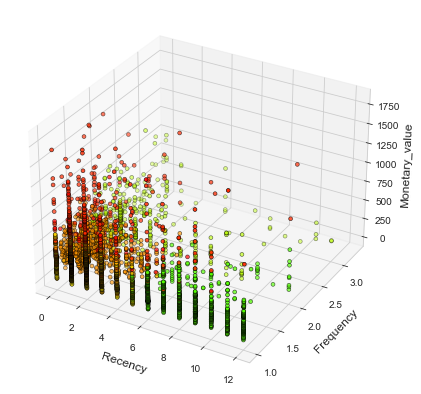

In [63]:
plot_3d(cluster_stats(kmeans, data, data_transformed)[1])

By examining cluster_summary dataframe, cluster_stats dataframe and the scatter plot above , it is interesting to see that each cluster indeed contains a group of consumers that have certain distinct and intrinsic features as detailed below.

# 4. Cluster analysis

Text(0.5, 1.0, 'Proportion of Population')

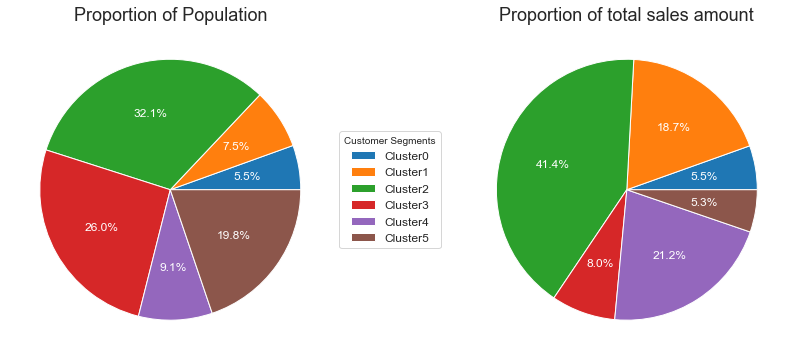

In [64]:
# Two Pie charts to compare clusters in terms of represented population proportion and total sales
# amount proportion
def func(pct):
    return "{:.1f}%".format(pct)

fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(15, 6), subplot_kw=dict(aspect="equal"))

wedges, text1, autotexts = ax[1].pie(kmeans_cs['%sales_amount'].values,
                                  autopct=lambda pct: func(pct),
                                  textprops=dict(color="w", fontsize= 12))
wedges, text2, autotexts = ax[0].pie(kmeans_cs['%customers'].values,
                                  autopct=lambda pct: func(pct),
                                  textprops=dict(color="w", fontsize= 12))
ax[0].legend(kmeans_cs.index,
          title="Customer Segments",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1), fontsize= 12)

ax[1].set_title("Proportion of total sales amount", fontsize= 18)
ax[0].set_title("Proportion of Population", fontsize= 18)

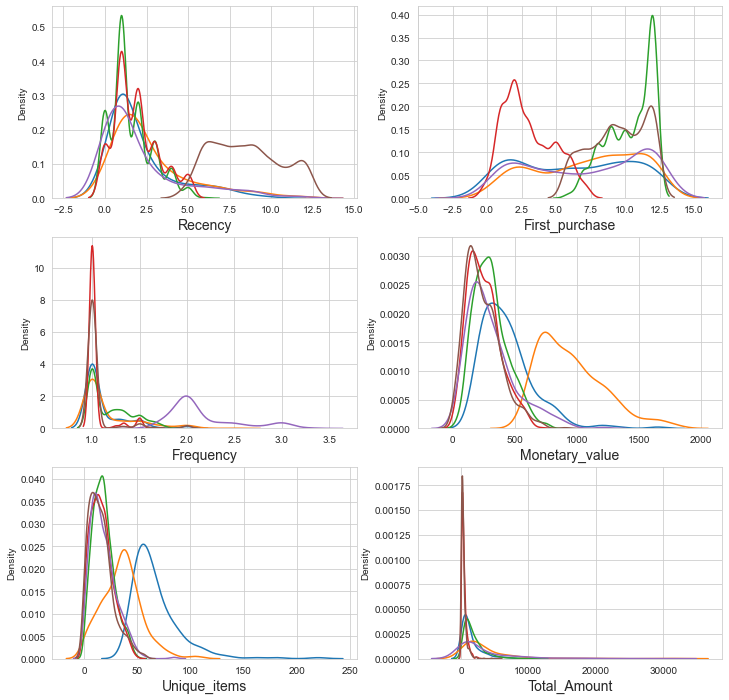

In [65]:
plot_dist(kmeans_results, ['Recency', 'First_purchase', 'Frequency', 'Monetary_value',
                           'Unique_items', 'Total_Amount'])

## Conclusion


### Cluster-0:
Customers are more recent in this cluster. This segment is the largest one, including 32% of the whole population and accounts for 41% of the total sales. This segment includes the loyal customers who started shopping with the online retailer in the first quarter of the year with an average first_purchase of 10.4 and maintained a moderate purchase frequency and high recency with an average of 1.6.<br/>

### Cluster-1:
Cluster1 includes 834 customers, representing 19.8% of the whole population and accounts for only 5.3% of he total sales amount. This group seems to be the least profitable group as none of the customers in this group purchased anything in the last five months of the year. Even for the first seven months of the year, the consumers didn't shop often, and the average value of frequency was only 1 transaction per month.

### Cluster-2:
Cluster2 contains 232 customers, composing 5% of the whole population and accounts for 5% of the total sales. This segment has fairly high profitability with an average monetary_value of £438 per transaction and moderate frequency with an average 1.1 transaction per month. What is interesting about this cluster is the large average number of unique items in each transaction. This indicates that most of customers in this segment are actually organizational customers not individuals. 

### Cluster-3:
Cluster3 contains 1096 customers, composed of 26% of the whole population and accounts for 8% of the total sales amount. This group includes new customers with an average first_purchase of 3 and average recency of 1.8


### Cluster-4:
Cluster4 contains about 9% of the whole population and accounts for 21% of the total sales amount. Customers in this segment shop frequently with an average frequency of 2.2 transaction per month. They also have moderate monetary-value, £308.7 per transaction. This segment can be considered as the second most profitable segment.
 
### Cluster-5:
Cluster5 contains 314 customers, composed of 7% of the whole population. This group seems to be the most profitable group as it accounts for 19% of the total sales amount. Most of the customers in this group have started shopping with the online retailer in the second quarter of the year with an average first_purchase of 7.2, and continued to the end of the year with an average recency of 2.7 months since last purchase. Also, customers in this group seems to shop frequently during the month with an average frequency of 1.2 transactions per month. Thus, this group can also be categorized as high recency and high frequency.


Now, we can use the resulted clusters to answer the following questions:<br/>
* Who are the most / least valuable customers to the business? What are the distinct characteristics of them?<br/>
* Who are the most / least loyal customers, and how are they characterized?
* What are customers' purchase behavior patterns? Which products / items have customers purchased together often? In which sequence the products have been purchased?
* What are the sales patterns in terms of various perspectives such as products/items, regions and time (weekly, monthly, quarterly, yearly and seasonally), and so on?

In [66]:
import joblib

In [67]:
joblib.dump(kmeans_results, "clustering_model.pkl")

['clustering_model.pkl']